In [1]:
using DifferentialEquations
using Plots
using DataFrames
using Peaks #For detecting oscillations
using Random
using Polyhedra #For creating convex hulls
using QHull #For creating convex hulls
using Surrogates
using AbstractGPs
using SurrogatesAbstractGPs

## Troubleshooting Hiscock Model

In [42]:
#Manually create repressilator to test
function oscillator(du, u, p, t)
    I = [0.1, 0, 0]
    k = 1

    du[1] = k*(phi(-u[3]) + I[1] - u[1])
    du[2] = k*(phi(-u[1]) + I[2] - u[2])
    du[3] = k*(phi(-u[2]) + I[3] - u[3])
end

tspan = [0, 100] #Span of time to integrate for
savetimes = LinRange(0, 100, 100) #linear space of points until final time
u0 = fill(0.1, N) #cannot change, can be learned
p = [] #empty for now, can change to include parameters to be varied later
prob = ODEProblem(oscillator, u0, tspan, p)
sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-6, saveat=savetimes)

┌ Warning: dt(1.4210854715202004e-14) <= dtmin(1.4210854715202004e-14) at t=0.004832143893210033, and step error estimate = 78.16594331724944. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Charlotte\.julia\packages\SciMLBase\kTUaf\src\integrator_interface.jl:599


retcode: DtLessThanMin
Interpolation: 1st order linear
t: 1-element Vector{Float64}:
 0.0
u: 1-element Vector{Vector{Float64}}:
 [0.1, 0.1, 0.1]

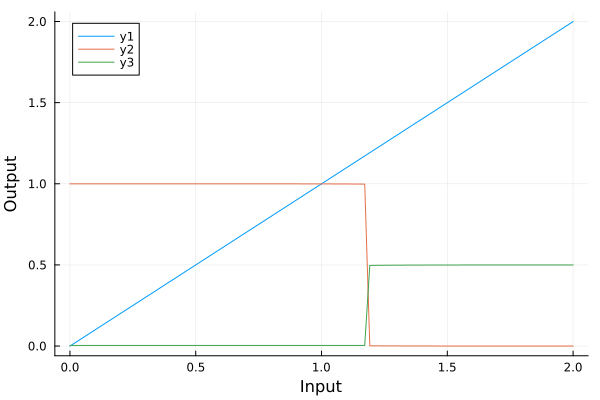

In [105]:
#Manually specify switch without matrix algebra and confirm results!
mm(x) = (1)/(1+exp(-x)) 
function switch(du, u, p, t)
    k, W, I = p
    du[1] = k*(I -u[1])
    du[2] = k*(mm(-5.5*u[1] + 12.9*u[2]) - u[2])
    du[3] = k*(mm(-5.6*u[2]) - u[3])
end

endtime = 10
resolution = 300 

tspan = [0, endtime] #Span of time to integrate for
savetimes = LinRange(0, endtime, resolution) #linear space of points until final time
u0 = [0, 0, 0] #cannot change, can be learned
 #empty for now, can change to include parameters to be varied later

sols = DataFrame()
for x in LinRange(0, 2, 100)
    p = [1, 0, x]
    prob = ODEProblem(switch, u0, tspan, p)
    sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-6, saveat=savetimes)
    sols = vcat(sols, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]]))
end
plot(LinRange(0, 2, 100), [sols.u1, sols.u2, sols.u3], xlabel="Input", ylabel="Output")

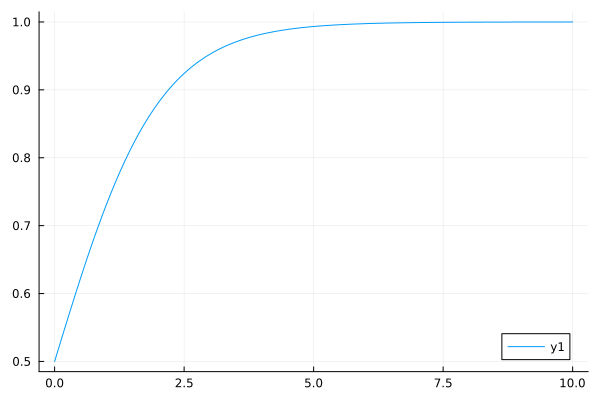

In [96]:
#Test various nonlinearities
savetimes = LinRange(0, 10, resolution)
phi(x) = 1/(exp(x) - 1)
mm(x) = (1)/(1+exp(-x))

plottimes = mm.(savetimes)
plot(savetimes, plottimes)

## Hiscock Model

In [2]:
#DEFINE HISCOCK MODEL
phi(x) = 1/(1+exp(-x)) #Nonlinearity
#Given N, W, I create a ODE function and run it
function hiscock_model(N, W, k, I, u0, endtime=100, resolution=200)
    function odes(du, u, p, t)
        k, W, I = p
        for i in 1:N
            du[i] = k[i]*(phi(transpose(W[i])*u) + I[i] - u[i])
        end
    end

    tspan = [0, endtime] #Span of time to integrate for
    savetimes = LinRange(0, endtime, resolution) #linear space of points until final time
    p = [k, W, I] #empty for now, can change to include parameters to be varied later

    prob = ODEProblem(odes, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-3, abstol=1e-6, saveat=savetimes)
    return sol
end

#Demonstrate function to match Hiscock results
# N = 3
# #I = [1, 0, 0]
# W = [[0, 0, 0], [-5.5, 12.9, 0], [0, -5.6, 0]]
# k = [1, 1, 1]
# u0 = fill(0.1, N) #cannot change, can be learned

# sols = DataFrame()
# for x in LinRange(0, 2, 100)
#     I = [x, 0, 0]
#     sol = hiscock_model(N, W, k, I, u0, 10, 300)
#     sols = vcat(sols, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]]))
# end
# plot(LinRange(0, 2, 100), [sols.u1, sols.u2, sols.u3], xlabel="Input", ylabel="Output")

hiscock_model (generic function with 3 methods)

## Searching for Steady States

In [155]:
#Determine number of steady states using BayesOpt method (scan initial conditions)
N = 3
I = [0, 0, 0]
W = [[3.6, -3.6, 0], [0, 3.2, -3.7], [-6.3, 0, 5.1]] #Oscillator
k = [3.3, 7.3, 1.0] # Oscillator 

W = [[0, 0, 0], [-5.5, 12.9, 0], [0, -5.6, 0]]
k = [1, 1, 1]
#Scan ICs:
ss = DataFrame()
for u in LinRange(0, 100, 10)
    u0 = fill(u, N)
    sol = hiscock_model(N, W, k, I, u0, 10, 300)
    osc_flag = false
    for i in N
        u1 =  [v[i] for v in sol.u]
        pks, vals = findmaxima(u1)
        if length(pks) > 1
            osc_flag = true
        end
    end
    if osc_flag
        ss = vcat(ss, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]], "oscillatory" => [1]))
    else
        ss = vcat(ss, DataFrame("u1" => [sol.u[end][1]], "u2" => [sol.u[end][2]], "u3" => [sol.u[end][3]], "oscillatory" => [0]))
    end 
end

In [144]:
#Function that scans initial conditions using BayesOpt
function run_initial_conditions(N, W, u0)
    #Runs a simulation for a given set of initial conditions and returns the steady state and if it is oscillatory
    k = [1, 1, 1]
    I = [0, 0, 0]
    sol = hiscock_model(N, W, k, I, u0, 10, 300)
    #Check if simulation is oscillatory and detect steady state if not
    osc_flag = false
    for i in N
        u1 =  [v[i] for v in sol.u]
        pks, vals = findmaxima(u1)
        if length(pks) > 1
            osc_flag = true
        end
    end
    if osc_flag
        return 1, sol.u[end]
    else
        return 0, sol.u[end]
    end 
end

function create_convex_hull(points)
    #Instantiates list of convex hulls based on a set of points 
    #Returns hull and convex hull metric
    hull = chull(mapreduce(permutedims, vcat, points))
    return hull, hull.volume
end

function acquisition_function(data, model)
    #Scores a set of points with a preexisting model
    scores = []
    for i in 1:size(data)[1]
        ic = Tuple(data[i, :])
        push!(scores, model(ic))
    end
    return scores
end

function create_hulls_and_compute_volume(classes, samples)
    hulls = []
    total_volume = 0
    for c in unique(classes)
        class_indices = findall(x -> x == c, classes)
        hull_points = samples[class_indices, :]
        hull_points = [row[:] for row in eachrow(hull_points)]
        hull, vol = create_convex_hull(hull_points)
        total_volume = vol + total_volume
    end
    return hulls, total_volume
end

function scan_steady_states(W, n_init=25, n_iters=100)
    steady_states = []
    k = [1, 1, 1]
    I = [0, 0, 0]
    N = length(W)
    space_size = 10^N

    #Sample initial conditions broadly to create initial convex hulls 
    samples = 10*rand(n_init, N) #Max possible IC is 10, but this can be changed!
    classes = []
    for i in 1:n_init
        u0 = samples[i, :]
        osc, ss = run_initial_conditions(N, W, u0)
        if ss ∉ steady_states
            push!(steady_states, ss) #Add unknown steady states to list
        end
        if osc == 0
            push!(classes, string(round(abs(ss[1]), digits=2)))
        else
            #Remove sample from consideration/penalize it - DO THIS !!
        end            
    end

    #Remove each point and inflate convex hulls to score
    scores = []
    temp_hulls = []
    for i in 1:n_init
        rem_samples = vcat(samples[1:i-1, :], samples[i+1:end, :])
        rem_classes = vcat(classes[1:i-1], classes[i+1:end])
        total_volume = 0
        for ss in unique(classes)
            class_indices = findall(x -> x == ss, rem_classes)
            hull_points = rem_samples[class_indices, :]
            hull_points = [row[:] for row in eachrow(hull_points)]
            if length(class_indices) >= 3
                hull, vol = create_convex_hull(hull_points)
                push!(temp_hulls, hull)
                total_volume = vol + total_volume
            end
        end
        push!(scores, total_volume)
    end

    #Create current total hulls
    total_scores = []
    hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
    push!(total_scores, total_volume)

    #Train GPR to predict scores
    training_samples = [Tuple(row[:]) for row in eachrow(samples)]
    training_scores = [Float64(score) for score in scores]
    gp_surrogate = AbstractGPSurrogate(training_samples, training_scores)

    #Run BayesOpt loop
    sample_data = DataFrame()
    for i in 1:n_iters
        if total_scores[end]/space_size > 0.9 #FIX - need to normalize by total search space size!!
            break #Stop loop if reached 90% coverage
        end
        #Sample from posterior and select next sample
        n_rand = 100
        init_values = 10*rand(n_rand, N)
        options = acquisition_function(init_values, model) #Score possible options
        next_sample = init_values[argmax(options), :]

        next_osc_flag, next_result = run_initial_conditions(N, W, next_sample)
        next_class = string(round(abs(next_result[1]), digits=2))

        samples = vcat(samples, next_sample')
        classes = push!(classes, next_class)

        #Recompute hulls
        total_scores = []
        hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
        push!(total_scores, total_volume)
        push!(scores, total_volume)

        sample_data = vcat(sample_data, DataFrame("u1_i" => [next_sample[1]], "u2_i" => [next_sample[2]], "u3_i" => [next_sample[3]], "u1_f" => [next_result[1]], "u2_f" => [next_result[2]], "u3_f" => [next_result[3]], "score" => [total_scores[end]], "class" => [next_class], "conv" => [100*total_scores[end]/space_size]))

        #Refit GPR with new score
        training_samples = [Tuple(row[:]) for row in eachrow(samples)]
        training_scores = [Float64(score) for score in scores]
        gp_surrogate = AbstractGPSurrogate(training_samples, training_scores)
    end
    return sample_data
end

scan_steady_states (generic function with 3 methods)

Number of steady states: 1


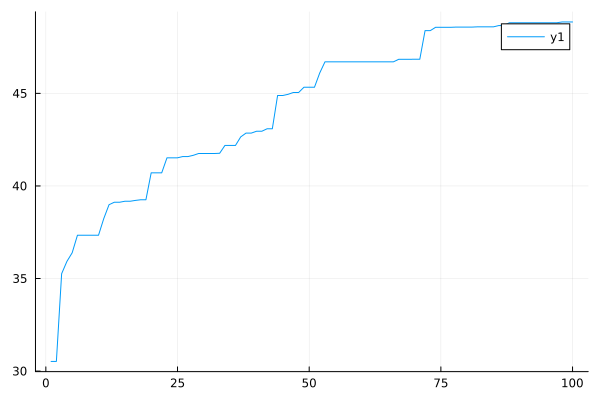

In [150]:
W = [[0, 0, 0], [-5.5, 12.9, 0], [0, -5.6, 0]]
sample_data =  scan_steady_states(W, 25, 100)
println("Number of steady states: ", length(unique(sample_data.class)))
plot(sample_data.conv)

# Next steps:
 - Find a sample network with known multiple steady states and test Method
 - Test convergence based on number of initial samples, rate of convergence (length of sampling run)